## What do we want to do?

#### Notation: 
- $\mathbb{N}$: Number of training points
- $\mathbb{L}$: Number of labels
- $BSZ$: Number of training points to load on GPU

#### Input: 
- X features: $\mathbb{X}_{i} ~ ~ \forall i \in \{1, \ldots, \mathbb{N}\}$
- Correct label set: $\mathbb{Y}_i ~ ~ \forall i \in \{ 1, \ldots, \mathbb{N}\}$

#### Output: Learnt 1vA weights:
- $\mathbb{D}_{l} ~ ~ \forall l \in \{1, \ldots, \mathbb{L}\}$
        
#### Methodology:
- Serialize all data
    - $\forall i \in {1, \ldots, \mathbb{N}}$:
        - $\forall j \in {1, \ldots, Nonzero(\mathbb{Y}_i})$:
            - $FinalData$.add($\{x_i, y_{i, j}\}$)


- GLaS regularizer preprocessing:
    - Calculate $\mathbb{G} \leftarrow \dfrac{AZ^{-1} + Z^{-1}A}{2}$ for all labels beforehand.
    - Since some of the labels can have 0 occurances, we manually enforce the entire rows and cols in $\mathbb{G}$ for all such labels to be 0


- Training: 
    - Randomly Init $\mathbb{D}_{l} ~ ~ \forall l \in \mathbb{L}$ on GPU
    - Transfer $\mathbb{G}$ on GPU
    
    - Until convergence:
        - Randomly shuffle $FinalData$ (To get different negatives)
        - $\forall i \in \{ 1, \ldots, \mathbb{N} ~ / ~ BSZ \}$:
            - $\mathbb{X}_{Batch}, \mathbb{Y}^{+}_{Batch}, \mathbb{Y}^{-}_{Batch} \ \leftarrow loadBatch(i)$
            - $\hat{\mathbb{Y}}_{Batch} \leftarrow \mathbb{D}_{Batch}^{T} \cdot \mathbb{X}_{Batch}$
            - $\mathbb{L}_{Batch} \leftarrow RankingLoss(\hat{\mathbb{Y}}_{Batch}, \mathbb{Y}^{+}_{Batch}, \mathbb{Y}^{-}_{Batch}) + \lambda \cdot \mathbb{L}_{GLaS}(\mathbb{G}, \mathbb{D})$
            - $Backprop(\mathbb{L}_{Batch})$


- $loadBatch(i)$:
    - $\mathbb{X}_{Batch}, \mathbb{Y}^{+}_{Batch} \leftarrow FinalData[i : i+BSZ]$
    - $\mathbb{Y}_{temp} \leftarrow \bigcup{\mathbb{Y}^{+}_{Batch}}$ // set
    - $\mathbb{Y}^{-}_{Batch} \leftarrow [ ~ ]$ // list
    - $\forall i \in \{ 1, \ldots, BSZ \}$:
        - $\mathbb{Y}^{-}_{Batch}$.append($\mathbb{Y}_{temp} - all\_positives(\mathbb{X}_{Batch}^{i})$)
    - yeild $\mathbb{X}_{Batch}, \mathbb{Y}^{+}_{Batch}, \mathbb{Y}^{-}_{Batch}$
    
    
#### Results:
- Eurlex-4k:

In [1]:
import numpy as np
import torch
import os
import gc
import time
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from subprocess import PIPE, run
from scipy.sparse import csr_matrix, csc_matrix
from torch.autograd import Variable

from utils import DataLoader, read_sparse

In [2]:
dataset = "EURLex-4K"

DATA_DIR = dataset + "/"
train_features_file = DATA_DIR + "trn_X_Xf.txt"
train_labels_file = DATA_DIR + "trn_X_Y.txt"
test_features_file = DATA_DIR + "tst_X_Xf.txt"
test_labels_file = DATA_DIR + "tst_X_Y.txt"

In [3]:
print("Reading data files..")
train_x = DataLoader(train_features_file, train_labels_file)
num_train_points = train_x.num_points
num_labels = train_x.num_labels
vocab_x = train_x.num_words

test_x = DataLoader(test_features_file, test_labels_file)
num_test_points = test_x.num_points

Reading data files..
2593
24
2074
18


In [4]:
# Helper function
def get_log_file_path(hyper_params):
    log_file  = 'logs/stochastic_' + hyper_params['dataset']
    log_file += '_embed_' + str(hyper_params['embedding_dim'])
    log_file += '_bsz_' + str(hyper_params['num_data_to_load_on_GPU'])
    log_file += '_lamda_' + str(hyper_params['lamda'])
    log_file += '_dropout_' + str(hyper_params['dropout'])
    log_file += '_lr_' + str(hyper_params['lr'])
    log_file += '_tf_' + str(hyper_params['tf'])
    log_file += '.txt'
    
    return log_file

In [5]:
def get_metrics(score_indices, scores, train_file = False):
    scores_new = scores.data.cpu().numpy().tolist()

    score_indices_new = []
    for i in range(score_indices.shape[0]): score_indices_new.append(score_indices[i].data.cpu().numpy().tolist())

    # Save score matrix to file
    out_str = str(scores.shape[0]) + " " + str(num_labels) + '\n'
    for point_num in range(len(scores)):
        t1 = (list(map(str, score_indices_new[point_num])))
        t2 = (list(map(str, scores_new[point_num])))
        t3 = [ t1[i] + ":" + t2[i] for i in range(len(t1)) ]
        out_str += ' '.join(t3) + '\n'
    f = open("score_mat_new.txt", "w")
    f.write(out_str)
    f.close()

    # Compute metrics
    if train_file == True: print("Computing train metrics..")
    else: print("Computing test metrics..")

    command = "python ../../Slice/Tools/python/metrics/calc_metrics.py --score_file score_mat_new.txt --trn_X_Y " 
    command += train_labels_file 
    
    command += " --tst_X_Y "
    if train_file == False: command += test_labels_file
    else: command += train_labels_file
    
    if dataset in [ "AmazonCat-13K", "AmazonTitles-300K" ]: command += " -A 0.6 -B 2.6"
    elif dataset in [ "Wiki10", "Wiki-500K", "WikiTitles-500K" ]: command += " -A 0.5 -B 0.4"
    elif dataset in [ "EURLex-4K" ]: command += " -A 0.55 -B 1.5"

    result = run(command, stdout=PIPE, stderr=PIPE, universal_newlines=True, shell=True)
    
    metrics = result.stdout
    print("\n".join(metrics.split("\n")[1:3]), "\n")
    
    return result.stdout
    
def evaluate(hyper_params, reader):
    
    # Initializing
    score_indices = torch.cuda.LongTensor(num_test_points, hyper_params['num_to_save'])
    scores = torch.cuda.FloatTensor(num_test_points, hyper_params['num_to_save'])

    with torch.no_grad():
        for x, offsets, tf, data_batch, bar in reader.iter_eval(
            bsz = hyper_params['num_data_to_load_on_GPU'],
            tf = hyper_params['tf']
        ):

            # Forward
            scores_batch = model(x, offsets, tf)

            # Storing top-k indices
            vals, inds = torch.topk(scores_batch, k = hyper_params['num_to_save'], sorted = True)
            scores[data_batch : data_batch + hyper_params['num_data_to_load_on_GPU'], :] = vals
            score_indices[data_batch : data_batch + hyper_params['num_data_to_load_on_GPU'], :] = inds
    
    # Metrics
    return get_metrics(score_indices, scores)

In [6]:
def get_label_coocc(label_file):
    [ rows, cols, data ], nr, nc = read_sparse(label_file, return_separate = True)
    
    # [ num_points x num_labels ]
    matrix = csr_matrix((data, (rows, cols)), shape = (nr, nc), dtype = np.float32)
    return (matrix.T @ matrix).todense()

def get_G(train_labels_file):
    # Computing label coocc
    label_cooccurence = torch.cuda.FloatTensor(
        get_label_coocc(train_labels_file)
    )
    num_labels = label_cooccurence.shape[1]
    
    # Getting zinv
    diag = torch.diag(label_cooccurence)
    diag[diag < 0.001] = 0.1 # For labels occuring zero times
    inv_diag = 1.0 / diag
    inv_diag[inv_diag > 1.0] = 0.0 # Setting labels occuring zero times to be zero
    
    ind = np.diag_indices(num_labels)
    zinv = torch.zeros(num_labels, num_labels).cuda()
    zinv[ind[0], ind[1]] = inv_diag # Will set only the diagonal

    # Getting azinv
    a_zinv = torch.matmul(label_cooccurence, zinv)

    # Getting `G`
    return Variable(0.5 * (a_zinv + a_zinv.t()), requires_grad = False)

# Pre-computing `G` for all labels beforehand
G = get_G(train_labels_file)

def get_glass_reg(w_t, all_ys):    
    global G
    
    # Normalize label embeddings to be unit norm 
    # since `G` has diagonal entries 1 (by construction)
    # Shape of `w_t`: [ features x num_labels ]
    w_t = w_t / torch.norm(w_t, dim = 0).unsqueeze(0)
    
    # Selecting only those labels which are active in this batch
    w_t_batch = w_t[:, all_ys]
    G_batch = G[all_ys, :][:, all_ys]
    
    glas  = torch.matmul(w_t_batch.t(), w_t_batch)
    glas -= G_batch
    
    return torch.sum(glas ** 2) #/ (float(w_t_batch.shape[1]) ** 2)

def compute_loss_multilabel(output, y, negs):
    pos_scores = output.gather(-1, y).unsqueeze(1)
    
    # Padded elements in `negs` are padded with `num_labels`
    # Pad last dimension with -INF so that padded elements in `y` get -INF
    output = F.pad(output, pad=(0, 1), mode="constant", value = -float(1e5))
    neg_scores = output.gather(-1, negs).unsqueeze(-1)
    output = output[:, :-1]
    
    # Since we have -INF for padded elements in `neg_scores`
    # taking max with 0.0 would reduce them to zero
    loss = torch.clamp(1.0 + neg_scores - pos_scores, min = 0.0)
    
    # shape of `loss` should be [bsz x neg x pos]
    # We take sum for all pos, negs
    return torch.mean(torch.sum(torch.sum(loss, -1), -1))

In [ ]:
hyper_params = {
    'dataset': dataset,
    
    'num_data_to_load_on_GPU': int(256), # BSZ
    'embedding_dim': 1024, # Word & label embedding dimension
    'dropout': 0.2, # Word dropout
    'tf': False, # Whether to use TF-IDF weighted sum of embeddings
    
    'num_to_save': 5, # These many predictions will be saved for computing metrics
}

class Net(nn.Module):
    def __init__(self, hyper_params, vocab_x, num_labels):
        super(Net, self).__init__()
        
        self.hyper_params = hyper_params
        
        self.word_embedding_matrix = nn.EmbeddingBag(
            vocab_x, hyper_params['embedding_dim'], mode='sum', 
        )
        nn.init.xavier_uniform_(self.word_embedding_matrix.weight.data)
        
        self.linear1 = nn.utils.weight_norm(
            nn.Linear(hyper_params['embedding_dim'], hyper_params['embedding_dim']),
            name = 'weight'
        )
        self.linear2 = nn.utils.weight_norm(
            nn.Linear(hyper_params['embedding_dim'], num_labels, bias = False), 
            name = 'weight'
        )
        
        nn.init.xavier_uniform_(self.linear1.weight.data)
        nn.init.xavier_uniform_(self.linear2.weight.data)
                
        self.relu = nn.ReLU()
        self.dropout_val = hyper_params['dropout']

    def embed(self, x, offsets, tf):
        if self.hyper_params['tf'] == True:
            return self.word_embedding_matrix(x, offsets, per_sample_weights = tf)
        
        return self.word_embedding_matrix(x, offsets)
        
    def forward(self, x, offsets, tf):
        # Get document embeddings
        temp = self.relu(self.embed(x, offsets, tf)) # Non-linear
        temp = self.linear1(temp) # Linear
        
        # Calculate scores
        temp = self.linear2(temp)
        
        return temp

print("Training..")
start_time = time.time()

for bsz in [ 256 ]:
    
    hyper_params['num_data_to_load_on_GPU'] = bsz
    
    for tf in [ False, True ]:
        
        hyper_params['tf'] = tf
        
        if hyper_params['tf'] == True: hyper_params['lr'] = float(5e-5)
        else: hyper_params['lr'] = float(1e-3)
        
        for lamda in [ 0.0, 1.0, 10.0, float(1e2), float(1e3) ]:
            
            hyper_params['lamda'] = lamda
            
            # Log file path
            hyper_params['log_file'] = get_log_file_path(hyper_params)
            
            # Clear log file
            f = open(hyper_params['log_file'], "w")
            f.write("")
            f.close()
            
            # Initializing score matrices for metric computation
            score_indices = torch.cuda.LongTensor(num_train_points, hyper_params['num_to_save'])
            scores = torch.cuda.FloatTensor(num_train_points, hyper_params['num_to_save'])
            
            # Initializing model and optim.
            model = Net(hyper_params, vocab_x, num_labels).cuda(); print(model)
            optim = torch.optim.SGD(model.parameters(), lr = hyper_params['lr'], momentum=0.9)
            crit  = compute_loss_multilabel
            
            # Training
            for epoch in range(100):
                hyper_params['epoch'] = epoch + 1
                print("Running epoch:", hyper_params['epoch'])

                av_glass = 0.0; av_loss = 0.0; done = 0.0

                for x, offsets, tf, y, all_ys, negs, pbar in train_x.iter(
                    dropout = hyper_params['dropout'], 
                    bsz = hyper_params['num_data_to_load_on_GPU'],
                    tf = hyper_params['tf']
                ):

                    # Forward pass
                    scores_for_all_labels = model(x, offsets, tf)

                    # Loss computation
                    loss = crit(scores_for_all_labels, y, negs)
                    glass_reg = get_glass_reg(model.linear2.weight.t(), all_ys)
                    av_glass += float(glass_reg)
                    loss += (lamda) * glass_reg

                    # Backward & optimizing
                    optim.zero_grad()
                    loss.backward()
                    optim.step()

                    # Storing loss
                    av_loss += float(loss.data); done += 1.0
                    
                    # Updating TQDM
                    pbar.set_description(
                        "L: " + str(lamda) + \
                        ", G: " + str(round(av_glass / done, 4)) + \
                        ", Total: " + str(round(av_loss / done, 4))
                    )

                # Computing metrics on test set at epoch end
                with torch.no_grad(): metrics = evaluate(hyper_params, test_x)
                
                # Logging at epoch end
                f = open(hyper_params['log_file'], "a")
                f.write("Epoch #" + str(hyper_params['epoch']) + ":\n")
                f.write("Lamda:" + str(lamda) + ", Glass: " + str(round(av_glass / done, 4)) + ", Total loss: %8f" % (av_loss / done) + "\n")
                f.write(metrics + "\n")
                f.close()

Training..
Net(
  (word_embedding_matrix): EmbeddingBag(5000, 1024, mode=sum)
  (linear1): Linear(in_features=1024, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=3993, bias=False)
  (relu): ReLU()
)
Running epoch: 1



Computing test metrics..
Pk:	1: 40.98	3: 32.00	5: 26.40
PSPk:	1: 14.76	3: 16.87	5: 18.18 

Running epoch: 2



Computing test metrics..
Pk:	1: 49.44	3: 38.93	5: 32.09
PSPk:	1: 18.90	3: 21.42	5: 23.23 

Running epoch: 3



Computing test metrics..
Pk:	1: 54.71	3: 42.36	5: 34.53
PSPk:	1: 21.30	3: 24.17	5: 25.90 

Running epoch: 4



Computing test metrics..
Pk:	1: 58.20	3: 45.42	5: 37.24
PSPk:	1: 23.20	3: 26.46	5: 28.46 

Running epoch: 5



Computing test metrics..
Pk:	1: 60.09	3: 46.79	5: 38.25
PSPk:	1: 24.12	3: 27.52	5: 29.54 

Running epoch: 6



Computing test metrics..
Pk:	1: 60.70	3: 47.88	5: 38.93
PSPk:	1: 24.75	3: 28.57	5: 30.62 

Running epoch: 7



Computing test metrics..
Pk:	1: 61.77	3: 48.43	5: 39.89
PSPk:	1: 25.10	3: 28.91	5: 31.50 

Running epoch: 8



Computing test metrics..
Pk:	1: 63.53	3: 49.70	5: 40.54
PSPk:	1: 26.15	3: 30.17	5: 32.39 

Running epoch: 9



Computing test metrics..
Pk:	1: 63.61	3: 49.68	5: 40.65
PSPk:	1: 26.40	3: 30.40	5: 32.64 

Running epoch: 10



Computing test metrics..
Pk:	1: 64.98	3: 50.91	5: 42.00
PSPk:	1: 26.99	3: 31.32	5: 33.83 

Running epoch: 11



Computing test metrics..
Pk:	1: 65.40	3: 51.93	5: 42.34
PSPk:	1: 27.26	3: 31.93	5: 34.29 

Running epoch: 12



Computing test metrics..
Pk:	1: 66.34	3: 52.06	5: 42.67
PSPk:	1: 27.74	3: 32.10	5: 34.63 

Running epoch: 13



Computing test metrics..
Pk:	1: 66.71	3: 52.59	5: 43.11
PSPk:	1: 27.85	3: 32.58	5: 35.09 

Running epoch: 14



Computing test metrics..
Pk:	1: 65.61	3: 52.65	5: 43.48
PSPk:	1: 27.61	3: 32.71	5: 35.49 

Running epoch: 15



Computing test metrics..
Pk:	1: 67.03	3: 52.96	5: 43.69
PSPk:	1: 27.92	3: 32.79	5: 35.65 

Running epoch: 16



Computing test metrics..
Pk:	1: 67.60	3: 53.50	5: 43.83
PSPk:	1: 28.53	3: 33.28	5: 35.89 

Running epoch: 17



Computing test metrics..
Pk:	1: 67.47	3: 53.57	5: 44.30
PSPk:	1: 28.27	3: 33.24	5: 36.25 

Running epoch: 18



Computing test metrics..
Pk:	1: 67.29	3: 53.57	5: 43.76
PSPk:	1: 28.78	3: 33.83	5: 36.34 

Running epoch: 19



Computing test metrics..
Pk:	1: 68.65	3: 54.43	5: 44.48
PSPk:	1: 29.38	3: 34.27	5: 36.94 

Running epoch: 20



Computing test metrics..
Pk:	1: 68.65	3: 54.34	5: 44.45
PSPk:	1: 29.29	3: 34.36	5: 37.02 

Running epoch: 21



Computing test metrics..
Pk:	1: 68.15	3: 54.48	5: 44.93
PSPk:	1: 29.10	3: 34.14	5: 37.28 

Running epoch: 22


FileNotFoundError: [Errno 2] No such file or directory: 'logs/stochastic_EURLex-4K_embed_1024_bsz_256_lamda_1000.0_dropout_0.2_lr_0.001_tf_False.txt'

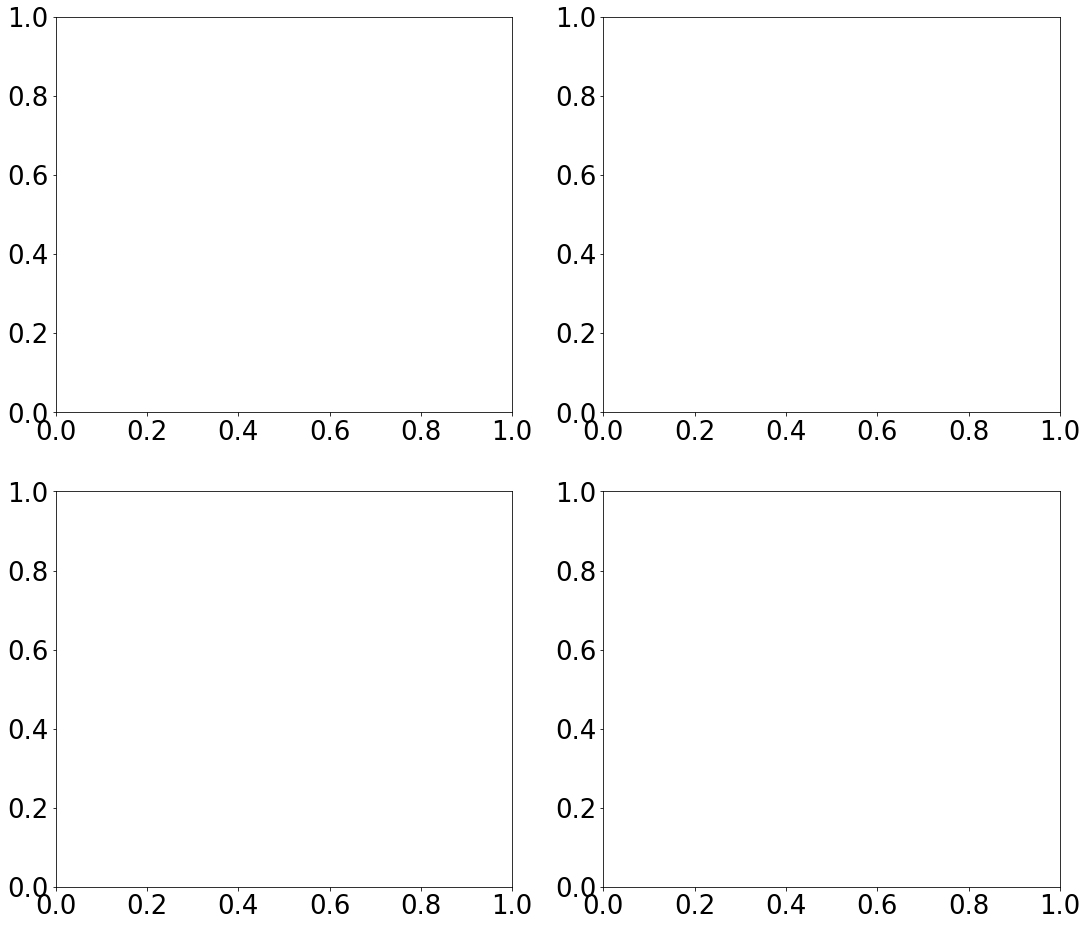

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

font = {
    'family' : 'DejaVu Sans',
    'weight' : 'normal',
    'size'   : 26
}

matplotlib.rc('font', **font)

metrics = [ 'Pk', 'PSPk' ]
lamdas = [ 0.0, 1.0, 10.0, float(1e2), float(1e3) ]

tf = False

fig, plts = plt.subplots(2, 2, figsize = (18, 16))

for at, tf in enumerate([ False, True ]):
    
    hyper_params['tf'] = tf
    
    x = []; y = {}
    for m in metrics: y[m] = { '1': [], '3': [], '5': [] }
        
    plt = plts[at]
    
    for lamda in lamdas:
        x.append(lamda + 1) # For when lamda = 0.0
        
        hyper_params['lamda'] = lamda

        if tf == True: hyper_params['lr'] = float(5e-5)
        else: hyper_params['lr'] = float(1e-3)

        log_file = get_log_file_path(hyper_params)
        f = open(log_file, "r")
        lines = f.readlines()
        f.close()

        y_temp = {}
        for m in metrics: y_temp[m] = { '1': [], '3': [], '5': [] }

        for i in range(len(lines)):
            line = lines[i].strip()

            if line[:5] == "Epoch":

                for j in range(i+3, i+9):

                    line = lines[j].strip()

                    if line.split(":")[0] in metrics:

                        y_temp[line.split(":")[0]]['1'].append(
                            float(line.split(":")[2].split()[0].strip())
                        )
                        y_temp[line.split(":")[0]]['3'].append(
                            float(line.split(":")[3].split()[0].strip())
                        )
                        y_temp[line.split(":")[0]]['5'].append(
                            float(line.split(":")[4].strip())
                        )

        for m in metrics:
            try: y[m]['1'].append(max(y_temp[m]['1']))
            except: y[m]['1'].append(0.0)
                
            try: y[m]['3'].append(max(y_temp[m]['3']))
            except: y[m]['3'].append(0.0)
                
            try: y[m]['5'].append(max(y_temp[m]['5']))
            except: y[m]['5'].append(0.0)

    plt[0].plot(x, y['Pk']['1'])
    plt[0].plot(x, y['Pk']['3'])
    plt[0].plot(x, y['Pk']['5'])
    plt[1].plot(x, y['PSPk']['1'])
    plt[1].plot(x, y['PSPk']['3'])
    plt[1].plot(x, y['PSPk']['5'])
    
    for i in range(2):
        if at == 1: plt[i].set_xlabel("$\lambda$")
        plt[i].set_xticks(x)
        plt[i].set_xscale('log')
        plt[i].set_title("TF-IDF = " + str(tf))
    plt[0].set_ylabel("P")
    plt[1].set_ylabel("PSP")

leg = ["@1", "@3", "@5"]
fig.legend(leg, ncol = 3)
fig.subplots_adjust(top = 0.9)

fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'logs/stochastic_EURLex-4K_embed_1024_bsz_256_lamda_1000.0_dropout_0.2_lr_0.001_tf_False.txt'

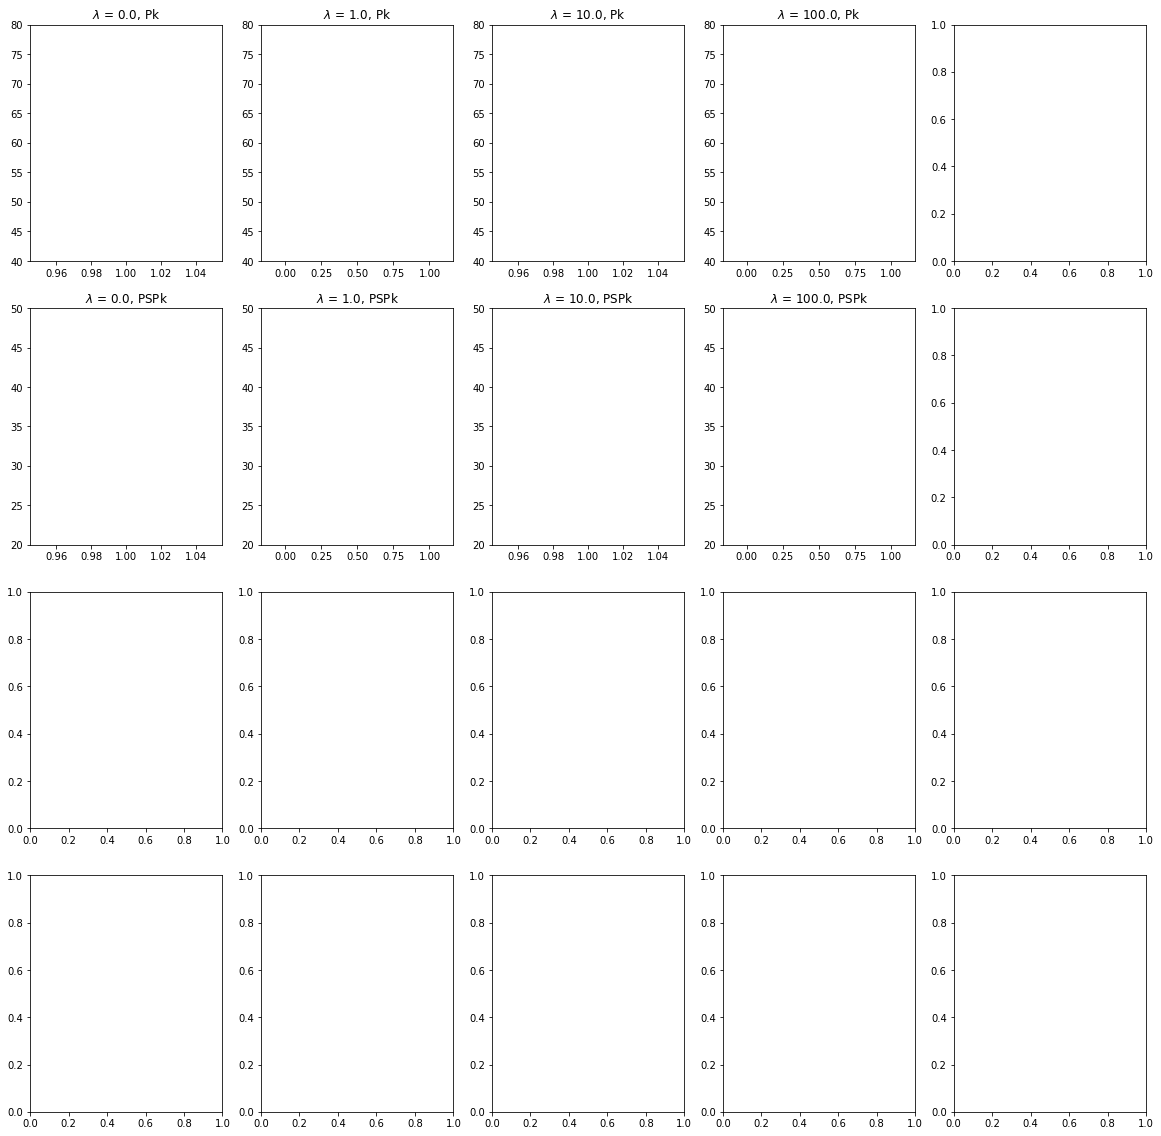

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

metrics = [ 'Pk', 'PSPk' ]
lamdas = [ 0.0, 1.0, 10.0, 100.0, float(1e3) ]

fig, plts = plt.subplots(len(metrics) * 2, len(lamdas), figsize = (20, 20))

for at_tf, tf in enumerate([ False, True ]):
    
    hyper_params['tf'] = tf
    
    for at2, lamda in enumerate(lamdas):
        
        hyper_params['lamda'] = lamda

        if tf == True: hyper_params['lr'] = float(5e-5)
        else: hyper_params['lr'] = float(1e-3)

        log_file = get_log_file_path(hyper_params)
        f = open(log_file, "r")
        lines = f.readlines()
        f.close()

        x = []; y = {}
        for m in metrics: y[m] = { '1': [], '3': [], '5': [] }

        for i in range(len(lines)):
            line = lines[i].strip()

            if line[:5] == "Epoch":

                check = False
                for j in range(i+3, i+9):
                        
                    if j >= len(lines): continue
                    line = lines[j].strip()

                    if line.split(":")[0] in metrics:
                        check = True

                        y[line.split(":")[0]]['1'].append(
                            float(line.split(":")[2].split()[0].strip())
                        )
                        y[line.split(":")[0]]['3'].append(
                            float(line.split(":")[3].split()[0].strip())
                        )
                        y[line.split(":")[0]]['5'].append(
                            float(line.split(":")[4].strip())
                        )

                if check == True: x.append(len(x) + 1)

        for at, m in enumerate(metrics):
            plts[at + (at_tf * len(metrics))][at2].plot(x, y[m]['1'])
            plts[at + (at_tf * len(metrics))][at2].plot(x, y[m]['3'])
            plts[at + (at_tf * len(metrics))][at2].plot(x, y[m]['5'])
            
            if at == len(metrics) - 1 and at_tf == 1:
                plts[at + (at_tf * len(metrics))][at2].set_xlabel("Epochs")
            
            title = "$\lambda$ = " + str(lamda) + ", " + metrics[at]
            if tf == True: title += ', TF-IDF'
            plts[at + (at_tf * len(metrics))][at2].set_title(title)

            if m == 'Pk': plts[at + (at_tf * len(metrics))][at2].set_ylim(40, 80)
            elif m == 'PSPk': plts[at + (at_tf * len(metrics))][at2].set_ylim(20, 50)

fig.show()